In [107]:
import os
import json
import pandas as pd

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

# Weighted avg.

In [ ]:
import json

with open(r"C:\Users\esual\Documents\local_repos\growth-vs-forgetting\data\results\llm_evaluations\results_DK.json\llm-stacking__LLM_7B_300BToken\results_2025-02-28T19-19-15.925070.json", "r") as f:
    data = json.load(f)

stem_subtasks = data["group_subtasks"]["mmlu_stem"]
print("Subtasks in mmlu_stem:", stem_subtasks)

Subtasks in mmlu_stem: ['mmlu_abstract_algebra', 'mmlu_high_school_chemistry', 'mmlu_college_biology', 'mmlu_computer_security', 'mmlu_college_chemistry', 'mmlu_college_physics', 'mmlu_college_mathematics', 'mmlu_high_school_biology', 'mmlu_machine_learning', 'mmlu_elementary_mathematics', 'mmlu_anatomy', 'mmlu_high_school_mathematics', 'mmlu_college_computer_science', 'mmlu_electrical_engineering', 'mmlu_high_school_computer_science', 'mmlu_astronomy', 'mmlu_conceptual_physics', 'mmlu_high_school_physics', 'mmlu_high_school_statistics']


In [174]:
results = data["results"]
n_samples = data["n-samples"]  # or data["n-samples"], depending on your output; here we'll assume n-shot

# Initialize accumulators
weighted_correct = 0.0
total_samples = 0

for task in stem_subtasks:
    # Get the accuracy for the subtask (e.g. the field "acc,none")
    # We assume the key exists in results[task] as "acc,none"
    subtask_result = results.get(task, {})
    accuracy = subtask_result.get("acc,none", None)
    
    # Get the effective sample count for the subtask
    subtask_samples = n_samples.get(task, {})
    effective_samples = subtask_samples.get("effective", None)
    
    if accuracy is None or effective_samples is None:
        print(f"Warning: Missing data for {task}")
        continue
    
    # Compute number of correct answers for this subtask
    weighted_correct += accuracy * effective_samples
    total_samples += effective_samples

print(f"Total effective samples: {total_samples}")


Total effective samples: 3153


In [175]:
if total_samples > 0:
    weighted_accuracy = weighted_correct / total_samples
    print(f"Weighted Overall Accuracy for mmlu_stem: {weighted_accuracy:.4f}")
else:
    print("No samples available to compute weighted accuracy.")


Weighted Overall Accuracy for mmlu_stem: 0.2718


In [178]:
stem_subtasks = data["group_subtasks"]["mmlu_humanities"]
print("Subtasks in mmlu_humanities:", stem_subtasks)

results = data["results"]
n_samples = data["n-samples"]  # or data["n-samples"], depending on your output; here we'll assume n-shot

# Initialize accumulators
weighted_correct = 0.0
total_samples = 0

for task in stem_subtasks:
    # Get the accuracy for the subtask (e.g. the field "acc,none")
    # We assume the key exists in results[task] as "acc,none"
    subtask_result = results.get(task, {})
    accuracy = subtask_result.get("acc,none", None)
    
    # Get the effective sample count for the subtask
    subtask_samples = n_samples.get(task, {})
    effective_samples = subtask_samples.get("effective", None)
    
    if accuracy is None or effective_samples is None:
        print(f"Warning: Missing data for {task}")
        continue
    
    # Compute number of correct answers for this subtask
    weighted_correct += accuracy * effective_samples
    total_samples += effective_samples

print(f"Total effective samples: {total_samples}")

if total_samples > 0:
    weighted_accuracy = weighted_correct / total_samples
    print(f"Weighted Overall Accuracy for mmlu_humanities: {weighted_accuracy:.4f}")
else:
    print("No samples available to compute weighted accuracy.")


Subtasks in mmlu_humanities: ['mmlu_international_law', 'mmlu_world_religions', 'mmlu_high_school_world_history', 'mmlu_formal_logic', 'mmlu_philosophy', 'mmlu_moral_disputes', 'mmlu_professional_law', 'mmlu_high_school_us_history', 'mmlu_moral_scenarios', 'mmlu_logical_fallacies', 'mmlu_jurisprudence', 'mmlu_high_school_european_history', 'mmlu_prehistory']
Total effective samples: 4705
Weighted Overall Accuracy for mmlu_humanities: 0.2417


In [ ]:
def collect_results_into_table(base_dir):
    """
    Recursively walk through `base_dir` to find each category folder (e.g. Bias, RC, RK, RS).
    Within each category folder, find each model subfolder, and load the single JSON file inside.
    
    Extracts:
      - category (the folder name, e.g. 'Bias')
      - model name (from the JSON metadata, or fallback to subfolder name)
      - total_evaluation_time_seconds
      - each task's metrics under "results"
    
    Returns a Pandas DataFrame with one row per (category, model, task).
    """
    rows = []

    # Iterate over top-level subfolders, which represent categories (e.g. 'Bias', 'RC', etc.)
    for category_name in os.listdir(base_dir):
        category_path = os.path.join(base_dir, category_name)
        if not os.path.isdir(category_path):
            continue  # Skip if it's not a directory
        
        # Within each category, each subfolder is presumably a model
        for model_folder in os.listdir(category_path):
            model_path = os.path.join(category_path, model_folder)
            if not os.path.isdir(model_path):
                continue  # Skip if not a directory
            
            # Find the JSON file(s) in this model folder
            for filename in os.listdir(model_path):
                if filename.endswith(".json"):
                    file_path = os.path.join(model_path, filename)
                    
                    with open(file_path, "r", encoding="utf-8") as f:
                        data = json.load(f)
                    
                    # Extract model name and total evaluation time
                    model_name = data.get("model_name") or data.get("model_name_sanitized", model_folder)
                    total_eval_time = data.get("total_evaluation_time_seconds", None)
                    
                    # Iterate over tasks in "results"
                    results = data.get("results", {})
                    for task_name, metrics_dict in results.items():
                        row = {
                            "category": category_name,
                            "model": model_name,
                            "task": task_name,
                            "total_evaluation_time_seconds": total_eval_time
                        }
                        # Pull out relevant numeric metrics (e.g. "likelihood_diff,none", "pct_stereotype,none")
                        # Adjust these if you want more/different metrics
                        for metric_key, metric_value in metrics_dict.items():
                            # Only store if it's numeric
                            if isinstance(metric_value, (int, float)):
                                row[metric_key] = metric_value
                        
                        rows.append(row)
    
    df = pd.DataFrame(rows)
    return df

In [4]:

def compute_fg_metric(df, reference_model, metric_column="likelihood_diff,none"):
    """
    Computes the FG metric across tasks for each (model, category), comparing
    the specified 'metric_column' value to that of a 'reference_model'.
    
    The FG formula (per your snippet) for each task i is:
        FG_i = ((R^g_i - R^m_i) / R^g_i) * 100
    where R^g_i is the reference model's performance, and R^m_i is the current model's performance.
    
    We'll then average FG_i across tasks for each model & category.
    
    Returns a DataFrame with columns:
      [model, category, FG (averaged), # tasks included, ...]
    """
    # First, isolate the reference model's rows
    ref_df = df[df["model"] == reference_model].copy()
    
    # We only need [category, task, metric_column] from the reference
    ref_df = ref_df[["category", "task", metric_column]].rename(
        columns={metric_column: metric_column + "_ref"}
    )
    
    # Merge original df with reference df on [category, task]
    merged = df.merge(ref_df, on=["category", "task"], how="inner", suffixes=("", "_ref"))
    
    # Exclude rows where the model is actually the reference (no need to compare reference to itself)
    merged = merged[merged["model"] != reference_model].copy()
    
    # Compute FG per row (per task)
    # FG = ((R^g - R^m) / R^g) * 100
    # Where R^g = merged[metric_column + "_ref"] (the reference's metric)
    #       R^m = merged[metric_column] (this model's metric)
    # NOTE: If your metric is an error metric or "lower is better", you might want the sign reversed.
    #       Adjust accordingly.
    merged["FG"] = ((merged[metric_column + "_ref"] - merged[metric_column]) 
                    / merged[metric_column + "_ref"]) * 100
    
    # Now group by (model, category) to average across tasks
    fg_summary = merged.groupby(["model", "category"], as_index=False).agg(
        FG_mean=("FG", "mean"),
        FG_std=("FG", "std"),
        tasks_count=("task", "count")
    )
    
    return fg_summary

In [4]:
# Example usage:
base_dir = r"C:\Users\esual\Documents\local_repos\growth-vs-forgetting\data\results\stack_evaluations"

# 1. Collect all results into a DataFrame
df_metrics = collect_results_into_table(base_dir)

# 2. Suppose you have a known reference model's name:
reference_model_name = "llm-stacking/StackLLM_7B_300BToken"

# 3. Compute FG for 'likelihood_diff,none' comparing each model to the reference
df_fg = compute_fg_metric(df_metrics, reference_model=reference_model_name,
                          metric_column="likelihood_diff,none")

# Now you have two tables in memory:
# df_metrics => the raw table of metrics
# df_fg      => the FG metric summary

# You can inspect them, print them, or save them as you wish.
print("=== Raw Metrics Table ===")
print(df_metrics.head())

print("\n=== FG Metric Summary ===")
print(df_fg.head())


=== Raw Metrics Table ===
            category                               model  \
0  results_Bias.json  llm-stacking/StackLLM_7B_300BToken   
1  results_Bias.json  llm-stacking/StackLLM_7B_300BToken   
2  results_Bias.json  llm-stacking/StackLLM_7B_300BToken   
3  results_Bias.json  llm-stacking/StackLLM_7B_300BToken   
4  results_Bias.json  llm-stacking/StackLLM_7B_300BToken   

                             task total_evaluation_time_seconds  \
0             crows_pairs_english            152.46037297998555   
1         crows_pairs_english_age            152.46037297998555   
2       crows_pairs_english_autre            152.46037297998555   
3  crows_pairs_english_disability            152.46037297998555   
4      crows_pairs_english_gender            152.46037297998555   

   likelihood_diff,none  likelihood_diff_stderr,none  pct_stereotype,none  \
0              3.699161                     0.104245             0.607036   
1              3.898430                     0.388829    

In [5]:
# Example usage:
base_dir = r"C:\Users\esual\Documents\local_repos\growth-vs-forgetting\data\results\stack_evaluations"

# 1. Collect all results into a DataFrame
df_metrics = collect_results_into_table(base_dir)

In [6]:
# Example usage:
base_dir = r"C:\Users\esual\Documents\local_repos\growth-vs-forgetting\data\results\llm_evaluations"

# 1. Collect all results into a DataFrame
df_metrics_llm = collect_results_into_table(base_dir)

In [11]:
df_all = pd.concat([df_metrics, df_metrics_llm])
df_all['category'] = df_all['category'].str.replace('.json', '').str.split('_').str[1]

In [29]:
df_all['model_'] = df_all.model.apply(lambda x: x.split('/')[-2] if 'llm-stacking' not in x else x.split('/')[-1])
df_all.rename(columns={'model':'model_long', 'model_': 'model'}, inplace=True)

In [63]:
df_all['model_type'] = df_all.model.apply(lambda x: 'Stacked' if 'stack' in x.lower() else 'LLM')
df_all['model_order'] = df_all.model.apply(lambda x: x.split('_')[-2][1] if 'm' in x else 0)

In [64]:
df_all

,category,model_long,task,total_evaluation_time_seconds,likelihood_diff,likelihood_diff_stderr,pct_stereotype,pct_stereotype_stderr,acc,acc_stderr,...,r@1,r@1_stderr,r@2,r@2_stderr,mrr,mrr_stderr,model,metric,model_type,model_order
0,Bias,llm-stacking/StackLLM_7B_300BToken,crows_pairs_english,152.46037297998555,3.699161,0.104245,0.607036,0.011930,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,StackLLM_7B_300BToken,3.699161,Stacked,0
1,Bias,llm-stacking/StackLLM_7B_300BToken,crows_pairs_english_age,152.46037297998555,3.898430,0.388829,0.692308,0.048650,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,StackLLM_7B_300BToken,3.898430,Stacked,0
2,Bias,llm-stacking/StackLLM_7B_300BToken,crows_pairs_english_autre,152.46037297998555,5.022820,2.150788,0.636364,0.152120,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,StackLLM_7B_300BToken,5.022820,Stacked,0
3,Bias,llm-stacking/StackLLM_7B_300BToken,crows_pairs_english_disability,152.46037297998555,5.750080,0.640899,0.753846,0.053846,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,StackLLM_7B_300BToken,5.750080,Stacked,0
4,Bias,llm-stacking/StackLLM_7B_300BToken,crows_pairs_english_gender,152.46037297998555,2.997492,0.230166,0.659375,0.026534,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,StackLLM_7B_300BToken,2.997492,Stacked,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,Rs,/dss/dsshome1/02/ra95kix2/seminar_fma/growth-v...,hellaswag,641.7913126419298,NaN,NaN,NaN,NaN,0.430990,0.004942,...,NaN,NaN,NaN,NaN,NaN,NaN,llm_7b_m2_prompt,0.430990,LLM,2
266,Rs,/dss/dsshome1/02/ra95kix2/seminar_fma/growth-v...,mathqa,641.7913126419298,NaN,NaN,NaN,NaN,0.227806,0.007678,...,NaN,NaN,NaN,NaN,NaN,NaN,llm_7b_m2_prompt,0.227806,LLM,2
267,Rs,/dss/dsshome1/02/ra95kix2/seminar_fma/growth-v...,mutual,641.7913126419298,NaN,NaN,NaN,NaN,NaN,NaN,...,0.225734,0.014053,0.430023,0.016642,0.667607,0.010436,llm_7b_m2_prompt,0.225734,LLM,2
268,Rs,/dss/dsshome1/02/ra95kix2/seminar_fma/growth-v...,piqa,641.7913126419298,NaN,NaN,NaN,NaN,0.685528,0.010833,...,NaN,NaN,NaN,NaN,NaN,NaN,llm_7b_m2_prompt,0.685528,LLM,2


In [30]:
df_all.columns = df_all.columns.str.replace(',none', '')

In [38]:
df_all.category.unique()

array(['Bias', 'DK', 'RC', 'Rs'], dtype=object)

In [43]:
'mmlu_stem' in df_all.query('model == "LLM_7B_300BToken" and category == "RC"').task.unique()

False

In [56]:
mapping = {}
for i, key in df_all[['category', 'task']].drop_duplicates().iterrows():
    if key['category'] == 'Bias':
        mapping[key['task']] = 'likelihood_diff'
    elif key['category'] == 'Rs':
        if key['task'] == 'mutual':
            mapping[key['task']] = 'r@1'
        else:
            mapping[key['task']] = 'acc'
    elif key['category'] == 'RC':
        mapping[key['task']] = 'acc'
    elif key['category'] == 'DK':
        if key['task'] in ['mmlu_stem', 'mmlu_humanities', 'mmlu_social_sciences', 'mmlu_other']:
            mapping[key['task']] = 'acc'

In [57]:
df_all['metric'] = df_all.apply(lambda row: row[mapping[row['task']]] if row['task'] in mapping else None, axis=1)

In [58]:
df_all.dropna(subset=['metric']).pivot_table(columns='model', index=['category','task'], values='metric', aggfunc='sum').reset_index()

model,category,task,LLM_7B_300BToken,StackLLM_7B_300BToken,llm_7b_m1_prompt,llm_7b_m2_prompt,stack_7b_m1_prompt,stack_7b_m2_prompt
0,Bias,crows_pairs_english,3.607093,3.699161,6.029384,6.349035,5.115948,5.949831
1,Bias,crows_pairs_english_age,4.011856,3.898430,6.134419,6.846725,5.290221,6.589731
2,Bias,crows_pairs_english_autre,5.457950,5.022820,9.242189,9.306825,7.802008,7.069658
3,Bias,crows_pairs_english_disability,6.083663,5.750080,9.107424,10.256893,7.721784,9.299142
4,Bias,crows_pairs_english_gender,2.808408,2.997492,4.711070,5.213454,4.156662,4.603600
5,Bias,crows_pairs_english_nationality,3.432165,3.396676,5.397564,6.141367,4.701356,5.661812
6,Bias,crows_pairs_english_physical_appearance,3.435817,3.696245,6.362097,6.038505,5.032158,5.150097
7,Bias,crows_pairs_english_race_color,3.401968,3.683248,5.929988,6.121613,4.886715,5.569920
8,Bias,crows_pairs_english_religion,4.241820,3.878677,5.878857,6.118699,5.217178,6.563813
9,Bias,crows_pairs_english_sexual_orientation,3.915048,4.305975,7.556257,7.544505,6.920445,7.654505


In [66]:
df_all_clean = df_all[['model_type', 'model_order', 'model', 'category', 'task', 'metric']]
df_all_clean = df_all_clean.dropna(subset=['metric'])
df_all_clean['metric'] = df_all_clean['metric'].astype(float)
df_all_clean

,model_type,model_order,model,category,task,metric
0,Stacked,0,StackLLM_7B_300BToken,Bias,crows_pairs_english,3.699161
1,Stacked,0,StackLLM_7B_300BToken,Bias,crows_pairs_english_age,3.898430
2,Stacked,0,StackLLM_7B_300BToken,Bias,crows_pairs_english_autre,5.022820
3,Stacked,0,StackLLM_7B_300BToken,Bias,crows_pairs_english_disability,5.750080
4,Stacked,0,StackLLM_7B_300BToken,Bias,crows_pairs_english_gender,2.997492
...,...,...,...,...,...,...
265,LLM,2,llm_7b_m2_prompt,Rs,hellaswag,0.430990
266,LLM,2,llm_7b_m2_prompt,Rs,mathqa,0.227806
267,LLM,2,llm_7b_m2_prompt,Rs,mutual,0.225734
268,LLM,2,llm_7b_m2_prompt,Rs,piqa,0.685528


In [67]:
df_llm = df_all_clean.query('model_type == "LLM"')
df_stacked = df_all_clean.query('model_type == "Stacked"')

In [89]:
df_pivot_llm = df_llm.pivot(index=['category','task'], columns='model_order', values='metric')
df_pivot_stacked = df_stacked.pivot(index=['category','task'], columns='model_order', values='metric')

In [90]:
rel_drops = {}
for col in df_pivot_llm.columns:
    if col != 0:
        rel_drops[col] = (df_pivot_llm[0] - df_pivot_llm[col]) / df_pivot_llm[0]

df_rel_drops = pd.DataFrame(rel_drops)
df_pivot_llm['FG'] = df_rel_drops.mean(axis=1) * 100

In [91]:
rel_drops = {}
for col in df_pivot_stacked.columns:
    if col != 0:
        rel_drops[col] = (df_pivot_stacked[0] - df_pivot_stacked[col]) / df_pivot_stacked[0]

df_rel_drops = pd.DataFrame(rel_drops)
df_pivot_stacked['FG'] = df_rel_drops.mean(axis=1) * 100

<Axes: xlabel='model_order'>

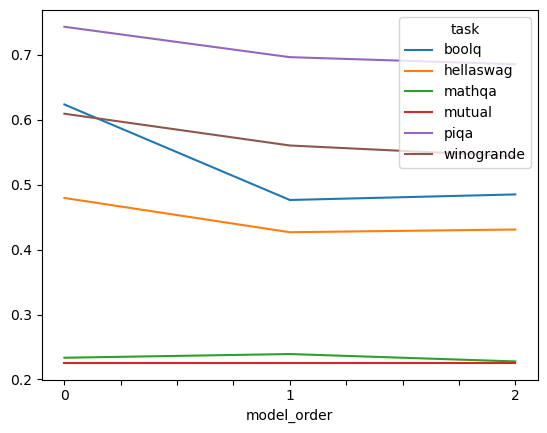

In [92]:
df_pivot_llm.loc['Rs'].iloc[:,:-1].T.plot()

In [94]:
df_pivot = df_all_clean.pivot(index=['model_type','category','task'], columns='model_order', values='metric')

In [100]:
df_pivot.reset_index(inplace=True)

In [177]:
df_pivot.query('task == "mmlu_stem"')

model_order,model_type,category,task,0,1,2
25,LLM,DK,mmlu_stem,0.271805,0.261973,0.278782
58,Stacked,DK,mmlu_stem,0.258167,0.251824,0.277513


In [170]:
df_rel_drops

1         2
category task                                                       
Bias     crows_pairs_english                     -0.383002 -0.608427
         crows_pairs_english_age                 -0.357013 -0.690355
         crows_pairs_english_autre               -0.553312 -0.407508
         crows_pairs_english_disability          -0.342900 -0.617220
         crows_pairs_english_gender              -0.386714 -0.535817
         crows_pairs_english_nationality         -0.384105 -0.666868
         crows_pairs_english_physical_appearance -0.361424 -0.393332
         crows_pairs_english_race_color          -0.326741 -0.512231
         crows_pairs_english_religion            -0.345092 -0.692281
         crows_pairs_english_sexual_orientation  -0.607173 -0.777647
         crows_pairs_english_socioeconomic       -0.446674 -0.796920
         crows_pairs_french                      -0.232897 -0.311827
         crows_pairs_french_age                  -0.166267 -0.133546
         crows_pairs_french_autre                -0.340707 -0.158825
         crows_pairs_french_disability            0.054338  0.007593
         crows_pairs_french_gender               -0.288660 -0.461675
         crows_pairs_french_nationality          -0.242864 -0.235606
         crows_pairs_french_physical_appearance  -0.340511 -0.572679
         crows_pairs_french_race_color           -0.283896 -0.416923
         crows_pairs_french_religion             -0.126145 -0.236183
         crows_pairs_french_sexual_orientation   -0.572625 -0.594960
         crows_pairs_french_socioeconomic        -0.136776 -0.173377
DK       mmlu_humanities                         -0.013228 -0.028219
         mmlu_other                              -0.098113 -0.060377
         mmlu_social_sciences                    -0.104520 -0.295198
         mmlu_stem                                0.024570 -0.074939
RC       race                                          NaN       NaN
Rs       boolq                                    0.127230  0.116432
         hellaswag                                0.097928  0.102228
         mathqa                                   0.055480  0.005413
         mutual                                   0.000000  0.000000
         piqa                                     0.067870  0.067148
         winogrande                               0.077111  0.094247

In [169]:
rel_drops = {}
for col in df_pivot.columns:
    if col != 0:
        rel_drops[col] = (df_pivot[0] - df_pivot[col]) / df_pivot[0]

df_rel_drops = pd.DataFrame(rel_drops)
df_pivot['FG'] = df_rel_drops.mean(axis=1) * 100

TypeError: unsupported operand type(s) for -: 'float' and 'str'

In [103]:
df_melt = pd.melt(df_pivot, id_vars=['model_type','category','task'], var_name='model_order', value_name='metric')

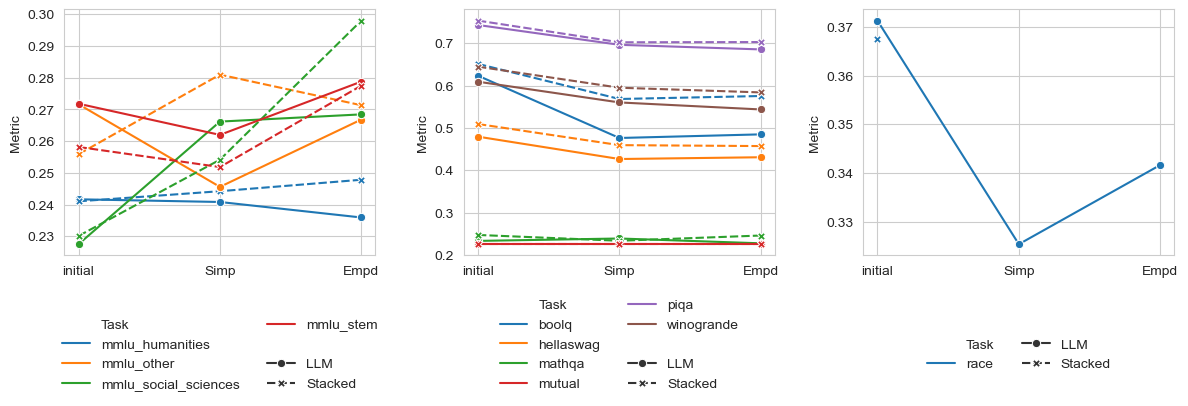

In [208]:
custom_labels = ["initial", "Simp", "Empd"]

fig, axs = plt.subplots(1,3, figsize=(12,5))
sns.lineplot(data=df_melt.query('category == "DK"'), x='model_order', y='metric', hue='task', style='model_type', markers=True, ax=axs[0])
sns.lineplot(data=df_melt.query('category == "Rs"'), x='model_order', y='metric', hue='task', style='model_type', markers=True, ax=axs[1])
sns.lineplot(data=df_melt.query('category == "RC"'), x='model_order', y='metric', hue='task', style='model_type', markers=True, ax=axs[2])
for ax in axs:
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5,-0.6), 
        ncol=2, title=None, frameon=False
    )
    legend = ax.get_legend()
    legend.texts[0].set_text("Task")
    # remove text from legend.texts[1]
    legend.texts[-3].set_text("")
    ax.set_xlabel("")
    ax.set_ylabel("Metric")
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(custom_labels)
    

    
plt.tight_layout()

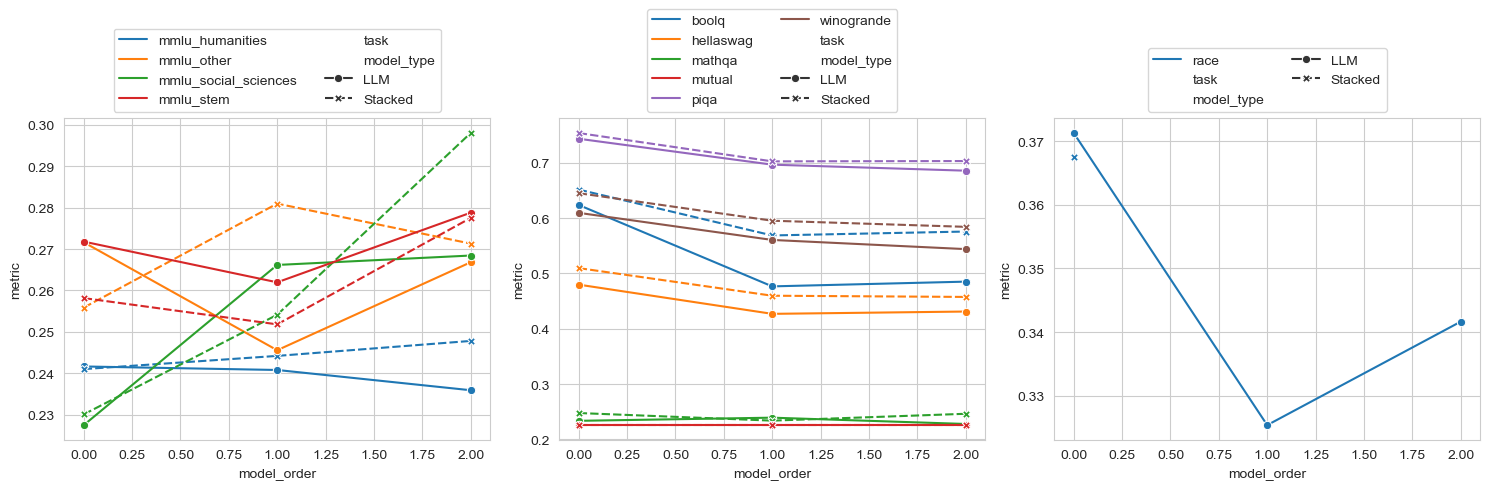

In [131]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
sns.lineplot(data=df_melt.query('category == "DK"'), x='model_order', y='metric', hue='task', style='model_type', markers=True, ax=axs[0])
sns.lineplot(data=df_melt.query('category == "Rs"'), x='model_order', y='metric', hue='task', style='model_type', markers=True, ax=axs[1])
sns.lineplot(data=df_melt.query('category == "RC"'), x='model_order', y='metric', hue='task', style='model_type', markers=True, ax=axs[2])
for ax in axs:
    # 1. Get the existing legend’s handles and labels
    handles, labels = ax.get_legend_handles_labels()
    
    # 2. Separate them into tasks vs. model_type
    #    (You might identify tasks by name, or by some known list)
    task_handles = []
    task_labels = []
    model_handles = []
    model_labels = []
    
    # Example: suppose you know the distinct labels for tasks vs. model_type
    known_tasks = {
        "mmlu_humanities","mmlu_other","mmlu_social_sciences","mmlu_stem",
        "boolq","hellaswag","mathqa","mutual","piqa","winogrande","race"
    }
    for h, l in zip(handles, labels):
        if l in known_tasks:
            task_handles.append(h)
            task_labels.append(l)
        else:
            model_handles.append(h)
            model_labels.append(l)
    
    # 3. Reorder them so that tasks come first, then model_type
    new_handles = task_handles + model_handles
    new_labels = task_labels + model_labels
    
    # 4. Create a new legend with 2 columns
    #    (ncol=2 typically arranges items row-wise:
    #       row1: item0, item1
    #       row2: item2, item3, etc.)
    ax.legend(new_handles, new_labels, ncol=2, title=None, frameon=True)
    
    # 5. Now reposition it at the bottom (or wherever) with move_legend
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(0.5, 1),  # or adjust Y further down if needed
        ncol=2,
        title=None
    )

plt.tight_layout()
plt.show()

In [209]:
df_tests = pd.read_csv(r'C:\Users\esual\Documents\local_repos\growth-vs-forgetting\src\utils\combined_metrics.csv')

In [211]:
df_tests['model_type'] = df_tests['model_folder'].str.split('_').str[0]
df_tests['model_size'] = df_tests['model_folder'].str.split('_').str[1]
df_tests['model_stage'] = df_tests['model_folder'].str.split('_').str[2]

In [226]:
df_tests.to_clipboard()